# 03 - Interactive Visualisation

## Background
In this homework we will practice with interactive visualization, which is the key ingredient of many successful viz (especially when it comes to infographics).
You will be working with the P3 database of the [SNSF](http://www.snf.ch/en/Pages/default.aspx) (Swiss National Science Foundation).
As you can see from their [entry page](http://p3.snf.ch/), P3 already offers some ready-made viz, but we want to build a more advanced one for the sake
of quick data exploration. Therefore, start by [downloading the raw data](http://p3.snf.ch/Pages/DataAndDocumentation.aspx) (just for the Grant Export), and read carefully
the documentation to understand the schema. Install then [Folium](https://github.com/python-visualization/folium) to deal with geographical data (*HINT*: it is not
available in your standard Anaconda environment, therefore search on the Web how to install it easily!) The README file of Folium comes with very clear examples, and links 
to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find a TopoJSON file with the 
geo-coordinates of each Swiss canton (which can be used as an overlay on the Folium maps).

## Assignment
1. Build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows intuitively (i.e., use colors wisely) how much grant money goes to each Swiss canton.
To do so, you will need to use the provided TopoJSON file, combined with the Choropleth map example you can find in the Folium README file.

*HINT*: the P3 database is formed by entries which assign a grant (and its approved amount) to a University name. Therefore you will need a smart strategy to go from University
to Canton name. The [Geonames Full Text Search API in JSON](http://www.geonames.org/export/web-services.html) can help you with this -- try to use it as much as possible
to build the canton mappings that you need. For those universities for which you cannot find a mapping via the API, you are then allowed to build it manually -- feel free to stop 
by the time you mapped the top-95% of the universities. I also recommend you to use an intermediate viz step for debugging purposes, showing all the universties as markers in your map (e.g., if you don't select the right results from the Geonames API, some of your markers might be placed on nearby countries...)

2. *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in research funding
between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

*HINT*: for those cantons cut through by the Röstigraben, [this viz](http://p3.snf.ch/Default.aspx?id=allcharts) can be helpful!


# 0. Getting the data
## Read the P3 data
The first step is to download and read the P3 database given by the [SNSF](http://p3.snf.ch/Pages/DataAndDocumentation.aspx) and load in into a dataframe.

We will use the usual suspects, imported below:

In [474]:
%matplotlib inline

import folium
import pickle
import seaborn as sns
import numpy as np
import requests
import re
import pandas as pd
import matplotlib.pyplot as pl
sns.set_context('notebook')

#### Data fields & description 

The P3 database contains the following fields :

* __Project Number__ -- uid
* __Project Title__ -- Name of the project. Mandatory field.
* __Project Title English__ -- Name of the project in English. Optional field.
* __Reponsible Applican__ -- Person who submitted the application to the SNSF. Mandatory field.
* __Funding Instrument__ -- Funding scheme
* __Funding Instrument Hierarchy__ -- Top Level Hierarchy Funding Instrument.
* __Institution__ -- Research institution where the project will largely be carried out. Typically, this is the institution or specific lab where the responsible applicant works. "This field is not structured, but its content is consolidated internally." There is no link in the database to the field University.
* __University__ -- This is the institution where the project will largely be carried out according to the application. Pick list. This field is only filled if the research is carried out at a Swiss institution, otherwise the field remains blank. In the case of mobility fellowships, it is generally left empty.
* __Discipline Number__ -- Number of the discipline. Only the main discipline from a list of disciplines supplied by the SNSF.
* __Discipline Name__ -- Name of the discipline. 
* __Discipline Name Hierarchy__ -- Top level of discipline.
* __Start Date__ -- Date on which the project starts.
* __End Date__ -- Actual end date of the project (updated if changed).
* __Approved Amount__ -- Approved amount, changed if the award is corrected. This amount is not indicated in the case of mobility fellowships.
* __Keywords__ -- unstructured field.
* __Abstract (Project)__ -- The scientific abstract of the research project. The researchers are responsible for the contents.
* __Lay Summary - Lead__ -- Summarise the most important information in the Lay Summary.
* __Lay Summary__ -- Summary of a research project aimed at laypeople. 

The API key below is "hidden", as we don't need to run the notebook anymore, since we cached the data we fetched from the API in a pickled file.

In [475]:
GAPI_KEY = '#################################'

Let's first load the row data, keeping only the columns we need, specifying what data should be treat as N/A, etc.

We don't need all these fields so we will select the following interesting ones and load them into a dataframe :

  * Project Number
  * Institution
  * University
  * Approved amount

In [476]:
cols = ['Project Number', 'Institution', 'University', 'Approved Amount']
na_values = ['data not included in P3', 'Nicht zuteilbar - NA']

dtypes = {
    'Approved Amount': np.float64
}

raw = pd.read_csv(
    'P3_GrantExport.csv',
    sep = ';',
    na_values=na_values,
    index_col='Project Number',
    dtype=dtypes,
    usecols=cols
)

df = raw.dropna()

Let's peek at the data:

In [477]:
df.sample(10)

,Institution,University,Approved Amount
Project Number,,,
149088,Laboratory of Energy Systems ENAC Swiss Fed. I...,EPF Lausanne - EPFL,216150.0
3498,Institut für Informatik Universität Zürich,Universität Zürich - ZH,89277.0
156282,Laboratoire des systèmes écologiques EPFL - EN...,"Eidg. Forschungsanstalt für Wald,Schnee,Land -...",476038.0
109767,Departement Chemie Universität Basel,Universität Basel - BS,421625.0
31100,Institut de Minéralogie et Pétrographie Univer...,Université de Lausanne - LA,30292.0
26428,Psychosomatik und Psychosoziale Medizin Psychi...,Universität Bern - BE,160619.0
31233,Observatoire de Genève Université de Genève,Université de Genève - GE,303100.0
58892,École des Hautes Études Commerciales Universit...,Université de Lausanne - LA,45634.0
116774,Soins Intensifs chirurgicaux Département APSIC...,Université de Genève - GE,260978.0


Let's see if the index is unique:

In [478]:
df.index.is_unique

True

Good news, every project number is unique!

Let's now try to guess the canton straight from the 'University' column:

In [479]:
with_canton = df.copy()

word_to_canton = {
    'bern': 'BE',
    'lausanne': 'VD',
    'genève': 'GE',
    'geneva': 'GE',
    'luzern': 'LU',
    'zürich': 'ZH',
    'lugano': 'TI',
    'basel': 'BS',
    'vaud': 'VD',
    'fribourg': 'FR',
    'davos': 'GR',
    'sagw': 'BE'
}

cantons = [
    'ZH','BE','LU','UR','SZ','OW','NW','GL','ZG','FR','SO','BS','BL',
    'SH','AR','AI','SG','GR','AG','TG','TI','VD','VS','NE','GE','JU'
]

# Tries to guess the canton by seeing if the given text
# contains a word defined in the dict above.
def guess_canton(text):
    lower = text.lower()
    for word in word_to_canton:
        if word in lower:
            return word_to_canton[word]
        
    return ''

# Extract an abbreviated canton name from the given string
def ex_canton_str(s):
    m = re.search(r'\b([A-Z]+)\b$', s.strip())
    if m != None and m.group(1) in cantons:
        return m.group(1)
    else:
        return ''

# Extrarct the canton from the given string, using the above function
def ex_canton(text, axis):
    guess = guess_canton(text)
    if guess:
        return guess
    
    res = text.split('-')
    
    if len(res) < 2: 
        return text.strip()
    else:
        return ex_canton_str(res[1])
        
# Extract the university name (dropping the canton suffix if any)
def ex_uni(text, axis):
    res = text.split('-')
    
    if len(res) < 2 or ex_canton_str(res[1]) == '':
        return text.strip()
    else:
        return res[0].strip()

# Let's add the guessed cantons and the refined universitity name to the dataframe
with_canton['Canton']     = with_canton['University'].apply(ex_canton, axis=1)
with_canton['University'] = with_canton['University'].apply(ex_uni, axis=1)

# Peek at it
with_canton.sample(10)

,Institution,University,Approved Amount,Canton
Project Number,,,,
160239,Slavisches Seminar Universität Zürich,Universität Zürich,268217.0,ZH
123370,Fakultät für Psychologie Universität Basel,Universität Basel,1283314.0,BS
162988,Département de Physique Université de Fribourg,Université de Fribourg,185794.0,FR
166321,Haute école de travail social et de la santé -...,HES de Suisse occidentale - HES-SO,343971.0,
120200,Ethik-Zentrum Universität Zürich,Universität Zürich,326603.0,ZH
139135,Institut de microtechnique EPFL - STI - IMT,EPF Lausanne - EPFL,1000000.0,VD
125051,Institut für Gymnasial- und Berufspädagogik Un...,Universität Zürich,302486.0,ZH
46398,BSS Volkswirtschaftliche Beratung AG,Firmen/Privatwirtschaft - FP,119420.0,
140572,"Abteilung Wirtschafts-, Sozial- und Umweltgesc...",Universität Bern,204255.0,BE


Let's now group those rows by canton and university, while summing the approved amounts.

In [480]:
grouped = with_canton.groupby(['Canton', 'University']).sum().reset_index()
grouped

,Canton,University,Approved Amount
0,,AO Research Institute - AORI,3.435621e+06
1,,Allergie- und Asthmaforschung - SIAF,1.916996e+07
2,,Biotechnologie Institut Thurgau - BITG,2.492535e+06
3,,Centre de rech. sur l'environnement alpin - CR...,1.567678e+06
4,,Eidg. Anstalt für Wasserversorgung - EAWAG,7.397585e+07
5,,"Eidg. Forschungsanstalt für Wald,Schnee,Land -...",4.836039e+07
6,,Eidg. Hochschulinstitut für Berufsbildung - EHB,2.086572e+06
7,,Eidg. Material und Prüfungsanstalt - EMPA,5.793069e+07
8,,Ente Ospedaliero Cantonale - EOC,5.067172e+06
9,,Fachhochschule Kalaidos - FHKD,1.090280e+06


To ease subsequent manipulations of the data, we now add a column that tells whether a row has an associated+know canton or not.

In [481]:
def is_known_canton(x, axis):
    return x.strip() in cantons

wc = grouped.copy()
wc['IsCanton'] = wc['Canton'].apply(is_known_canton, axis=1)

In [482]:
len(wc[wc['IsCanton'] == False])

53

In [483]:
wc[wc['IsCanton'] == False]

,Canton,University,Approved Amount,IsCanton
0,,AO Research Institute - AORI,3.435621e+06,False
1,,Allergie- und Asthmaforschung - SIAF,1.916996e+07,False
2,,Biotechnologie Institut Thurgau - BITG,2.492535e+06,False
3,,Centre de rech. sur l'environnement alpin - CR...,1.567678e+06,False
4,,Eidg. Anstalt für Wasserversorgung - EAWAG,7.397585e+07,False
5,,"Eidg. Forschungsanstalt für Wald,Schnee,Land -...",4.836039e+07,False
6,,Eidg. Hochschulinstitut für Berufsbildung - EHB,2.086572e+06,False
7,,Eidg. Material und Prüfungsanstalt - EMPA,5.793069e+07,False
8,,Ente Ospedaliero Cantonale - EOC,5.067172e+06,False
9,,Fachhochschule Kalaidos - FHKD,1.090280e+06,False


In [484]:
wc[wc['IsCanton']]

,Canton,University,Approved Amount,IsCanton
53,BE,Berner Fachhochschule - BFH,3.102870e+07,True
54,BE,Forschungskommission SAGW,1.000000e+05,True
55,BE,Pädagogische Hochschule Bern - PHBern,1.836136e+06,True
56,BE,Robert Walser-Stiftung Bern - RWS,5.695790e+05,True
57,BE,Universität Bern,1.490646e+09,True
58,BS,Staatsunabh. Theologische Hochschule Basel - STHB,1.730000e+04,True
59,BS,Universität Basel,1.326427e+09,True
60,FR,Haute école pédagogique fribourgeoise - HEPFR,1.547498e+06,True
61,FR,Université de Fribourg,4.480924e+08,True
62,GE,Université de Genève,1.810170e+09,True


We initially used the Geonames API but eventually switched to Google Places. We keep the code below for posterity.

In [485]:
def load_geo():
    '''
    params = {
        'username': 'ada_drs3',
        'country': 'CH',
        'type': 'json'
    }

    def geoname_query(q):
        params['q'] = q
        # print('Searching for %s...' % q)
        return requests.get('http://api.geonames.org/search', params)

    def search_by(col):
        for i in wc[wc['IsCanton'] == False].index:
            row = wc.iloc[i]
            res = geoname_query(row[col].strip())
            json = res.json()

            if json['totalResultsCount'] > 0:
                canton = json['geonames'][0]['adminCode1']
                print('=> Found ' + canton)
                wc.set_value(i,'Canton', canton)

    #search_by('University')
    #search_by('Canton')
    '''

Okay, let's get to business, and ask the almighty Google what they think of our data:

In [486]:
# Get the Google Place ID from the given university name
def get_place_id(uni):
    url = 'https://maps.googleapis.com/maps/api/place/textsearch/json?'
    params = {
        'query': uni,
         'key': GAPI_KEY
    }
    res = requests.get(url, params=params).json()
    if res['status'] == 'OK':
        return res['results'][0]['place_id']
    else:
        print(res)
        return None

In [487]:
# Query the Google Geocode API for information about the given Place ID.
def get_geocode_info(place_id):
    url = 'https://maps.googleapis.com/maps/api/geocode/json?'
    params = {
        'place_id': place_id,
        'key': GAPI_KEY
    }
    res = requests.get(url,params=params).json()
    if res['status'] == 'OK': 
        return res['results']
    else:
        print(res)
        return ''

We can now query the Google API, or just load the data we gathered last time from disk to avoid having to renew our API keys everytime we refresh the whole notebook.

In [488]:
query_api = False

place_ids = {}
geocodes = {}

if query_api:

    for i in wc.index:
        query = wc.iloc[i]['University']
        print('GMap request for %s' % query)
        place_ids[query] = get_place_id(query)
        if place_ids[query] != None:
            geocodes[query] = get_geocode_info(place_ids[query])
        else:
            geocodes[query]=None

    pickle.dump(place_ids, open('place_ids.p','wb'))
    pickle.dump(geocodes, open('geocodes.p','wb'))

else:
    place_ids = pickle.load(open('place_ids.p','rb'))
    geocodes  = pickle.load(open('geocodes.p','rb'))

Extract the relevant geographical information from the retrieved data:

In [489]:
# Get the canton's abbreviation from the given geocode object
def get_short_name(geocode):
    short_names = [
        comp['short_name']
        for comp in geocode['address_components']
        if 'administrative_area_level_1' in comp['types']
    ]
    
    if len(short_names) > 0:
        return short_names[0]
    else:
        return None

# Get the locality's name from the given geocode object
def get_locality(geocode):
    localities = [
        comp['long_name']
        for comp in geocode['address_components']
        if 'locality' in comp['types']
    ]
    
    if len(localities) > 0:
        return localities[0]
    else:
        return None

# Get the position (lat, long) from the given geocode object
def get_location(geocode):
    return geocode['geometry']['location']
    
# Aggregate the data fetched with the functions above into a dict.
def get_geo_info(geocode):
    if geocode == None or geocode[0] == None:
        return None

    return {
        'canton':   get_short_name(geocode[0]),
        'locality': get_locality(geocode[0]),
        'location': get_location(geocode[0])
    }

# To each university, associate the Geo info computed above
uni_geo_infos = {}

for uni in geocodes:
    uni_geo_infos[uni] = get_geo_info(geocodes[uni])

Merge the geographic information we gathered manually with the results retrieved from the Google API.

In [490]:
from uni_geo_infos_manual import uni_geo_infos_manual

for uni in uni_geo_infos_manual:
    uni_geo_infos[uni] = uni_geo_infos_manual[uni]

And merge this information with our main dataframe:

In [491]:
def load_from_uni_geo_info(uni, axis=None):
    if uni in uni_geo_infos and uni_geo_infos[uni] != None:
        return uni_geo_infos[uni]['canton']
    return ''

wc['Canton']   = wc['University'].apply(load_from_uni_geo_info, axis=1)
wc['IsCanton'] = wc['Canton'].apply(is_known_canton, axis=1)
wc[wc['IsCanton'] == False]

,Canton,University,Approved Amount,IsCanton
13,,Firmen/Privatwirtschaft - FP,1.091801e+08,False
16,HE,Forschungsinstitut für biologischen Landbau - ...,7.442410e+06,False
29,Lazio,Istituto Svizzero di Roma - ISR,1.410000e+05,False
31,,"NPO (Biblioth., Museen, Verwalt.) - NPO",3.229960e+08,False
45,,Schweizer Kompetenzzentrum Sozialwissensch. - ...,3.473282e+07,False
50,,Weitere Institute - FINST,9.256736e+06,False
51,,Weitere Spitäler - ASPIT,1.074981e+07,False


Let's now see how we're doing at the canton-guessing game:

In [492]:
from __future__ import division
print ('Number of entries: ' +  repr(len(wc)))
print ('Number of entries with known canton: ' + repr(len(wc)-len(wc[wc['IsCanton'] == False])))
print ('Ratio of missing cantons to total number of entries: ' + repr((len(wc)-len(wc[wc['IsCanton'] == False]))/len(wc)))

Number of entries: 76
Number of entries with known canton: 69
Ratio of missing cantons to total number of entries: 0.9078947368421053


Let's drop the rows with no matching cantons (displayed above) they are either no corresponding to a university or are located outside of Switzerland.

In [493]:
final_wc = wc[wc['IsCanton'] == True].drop(['IsCanton'], axis=1)
final_wc

,Canton,University,Approved Amount
0,GR,AO Research Institute - AORI,3.435621e+06
1,GR,Allergie- und Asthmaforschung - SIAF,1.916996e+07
2,TG,Biotechnologie Institut Thurgau - BITG,2.492535e+06
3,VS,Centre de rech. sur l'environnement alpin - CR...,1.567678e+06
4,ZH,Eidg. Anstalt für Wasserversorgung - EAWAG,7.397585e+07
5,ZH,"Eidg. Forschungsanstalt für Wald,Schnee,Land -...",4.836039e+07
6,BE,Eidg. Hochschulinstitut für Berufsbildung - EHB,2.086572e+06
7,ZH,Eidg. Material und Prüfungsanstalt - EMPA,5.793069e+07
8,TI,Ente Ospedaliero Cantonale - EOC,5.067172e+06
9,ZH,Fachhochschule Kalaidos - FHKD,1.090280e+06


Now that we've linked a canton to every university above, we can group them by canton and sum the amount of money allocated.

In [494]:
grouped_wc = final_wc.groupby('Canton').sum().reset_index()
grouped_wc

,Canton,Approved Amount
0,AG,1.152690e+08
1,BE,1.526267e+09
2,BL,3.476142e+06
3,BS,1.366673e+09
4,FR,4.496399e+08
5,GE,1.857647e+09
6,GR,3.653832e+07
7,JU,3.479035e+07
8,LU,4.882048e+07
9,NE,3.986158e+08


Some cantons do not appear in the above dataframe, either because they don't host a university, or because we failed to process the relevant information (though given which cantons are missing, the former is much more likely).

We're nonetheless going to add them to the dataframe, as Folium requires a corresponding row for each canton.

In [495]:
missing_cantons = [canton for canton in cantons if canton not in grouped_wc['Canton'].values]

with_all_cantons = grouped_wc.copy()

for canton in missing_cantons:
    data = {
        'Canton': [canton],
        'Approved Amount': [0]
    }
    df = pd.DataFrame.from_dict(data, orient='columns')
    
    with_all_cantons = with_all_cantons.append(df, ignore_index=True)

with_all_cantons

,Approved Amount,Canton
0,1.152690e+08,AG
1,1.526267e+09,BE
2,3.476142e+06,BL
3,1.366673e+09,BS
4,4.496399e+08,FR
5,1.857647e+09,GE
6,3.653832e+07,GR
7,3.479035e+07,JU
8,4.882048e+07,LU
9,3.986158e+08,NE


We now scale the approved amount per canton by million of swiss francs:

In [496]:
from math import pow
scaled_cantons = with_all_cantons.copy()
scaled_cantons['Approved Amount'] = with_all_cantons['Approved Amount'].div(pow(10, 6))
scaled_cantons

,Approved Amount,Canton
0,115.268969,AG
1,1526.266616,BE
2,3.476142,BL
3,1366.673453,BS
4,449.639858,FR
5,1857.646558,GE
6,36.538316,GR
7,34.790345,JU
8,48.820483,LU
9,398.615780,NE


And write the data down to a file, just in case.

In [497]:
pickle.dump(scaled_cantons, open('all_cantons.p','wb'))

## Visualisation

Now that we have collected all the necessary data we will try to visualise the results. We will use `Folium` to see the results on a map.

The data we have at our disposal is the following :

* `ch-cantons.topojson.json` : A topoJSON file which shows __borders between the 26 swiss cantons__.
* `all_cantons.p` : A pickle containing the __grant amounts for each canton__.
* `uni_geo_infos.p`: A pickle containing the __locations of all the universities__ found in the P3 database

In [498]:
# Data files
canton_overlay   = 'ch-cantons.topojson.json'
grants_by_canton = 'all_cantons.p'
uni_locations    = 'uni_geo_infos.p'

Let's load a map of Switzerland through `folium`, scaling it to see the entire country.

In [499]:
ch_center_loc = [46.92287,8.3829913] # Empirical "center" of Switzerland
map_ch = folium.Map(location=ch_center_loc, zoom_start=8)
map_ch.save('1_ch.html')

# You can view the map [here](https://rawgit.com/romac/ADAHomeworks/master/03%20-%20Interactive%20Viz/1_ch.html)

Now we will add an overlay with all the cantons, thanks to the topoJSON file.

In [500]:
folium.TopoJson(open(canton_overlay),
                'objects.cantons',
                name='topojson'
               ).add_to(map_ch)

map_ch.save('2_ch_canton_overlay.html')
map_ch

# You can view the map [here](https://rawgit.com/romac/ADAHomeworks/master/03%20-%20Interactive%20Viz/2_ch_canton_overlay.html)

We can now visualise the grant amounts by canton, by loading the processed data and displaying it in a __Choropleth map__. Note that the values displayed are in **MCHF**.

In [501]:
# Load the data
grants_by_canton_data = pickle.load(open(grants_by_canton,'rb')).reset_index()

# Plot a Choropleth map
cols = ['Canton', 'Approved Amount'] # Columns of interest
color_map = 'YlOrRd'                 # Color Map used, Yellow for low values, Red for high
scale = [0, 1, 10, 100, 1000, 5000]  # Custom semi-log scale for better visualisation
legend_str = 'Grant amount (MCHF)'   # Legend title

map_ch.choropleth(
    geo_path=canton_overlay, 
    data=grants_by_canton_data,
    columns=cols,
    topojson='objects.cantons',
    key_on='feature.id',
    fill_color=color_map,
    fill_opacity=0.7, 
    line_opacity=0.5,
    threshold_scale=scale,
    legend_name=legend_str,
    reset=True
)
map_ch.save('3ch_grant_overlay.html')
map_ch

# You can view the map [here](https://rawgit.com/romac/ADAHomeworks/master/03%20-%20Interactive%20Viz/3ch_grant_overlay.html)

We will now add the universities on the map.

In [502]:
# Load the data
unis = pickle.load(open(uni_locations,'rb'))

# Iterate over the dict and add a marker for each university
for key, val in unis.items():
    if val is not None:
        popup_str = key
        folium.Marker([val['location']['lat'], val['location']['lng']], popup=popup_str).add_to(map_ch)

In [508]:
map_ch.save('4_ch_canton_overlay_with_markers.html')
map_ch

# You can view the map [here](https://rawgit.com/romac/ADAHomeworks/master/03%20-%20Interactive%20Viz/4_ch_canton_overlay_with_markers.html)

---

# BONUS : Rostigraben

We will try to visualise the disparity on each side of the Röstigraben. First we will draw an approximate map of the cantons per language (approximate because cantons like Fribourg or Valais are bilingual and hence hard to seperate visually. Hence we made an **arbitrary** choice of considering Fribourg as German-speaking and Valais as French-speaking).

Let's start by mapping each canton to a language.

In [504]:
import pandas as pd

# Language assignements for visualisation on a map
DE = 0
FR = 1
IT = 2

# The canton to language mapping
cantons_lang = {
    'ZH' : DE,
    'BE' : DE,
    'LU' : DE,
    'UR' : DE,
    'SZ' : DE,
    'OW' : DE,
    'NW' : DE,
    'GL' : DE,
    'ZG' : DE,
    'FR' : DE,
    'SO' : DE,
    'BS' : DE,
    'BL' : DE,
    'SH' : DE,
    'AR' : DE,
    'AI' : DE,
    'SG' : DE,
    'GR' : DE,
    'AG' : DE,
    'TG' : DE,
    'TI' : IT,
    'VD' : FR,
    'VS' : FR,
    'NE' : FR,
    'GE' : FR,
    'JU' : FR
}

# Create a dataframe from this mapping
rosti_df = pd.DataFrame.from_dict(cantons_lang, orient='index')
rosti_df.reset_index(inplace=True)
rosti_df.rename(index=str, columns={'index': "Canton", 0:"Language"}, inplace=True)
rosti_df

,Canton,Language
0,NE,1
1,AI,0
2,AG,0
3,VD,1
4,VS,1
5,ZH,0
6,JU,1
7,OW,0
8,BL,0
9,SZ,0


Let's also provide a visualisation of our Rostigraben :

In [511]:
cantons_geo = './ch-cantons.topojson.json'
map_rosti = folium.Map(location=[46.92287,8.3829913], zoom_start=8)

map_rosti.choropleth(
    geo_path=cantons_geo, 
    data=rosti_pd,
    columns=['Canton', 'Language'],
    topojson='objects.cantons',
    key_on='feature.id',
    fill_color='YlOrRd',
    threshold_scale=[0, 1, 2],
    line_opacity=0.5
)

map_rosti.save('5_ch_rostigraben.html')
map_rosti

# You can view the map [here](https://rawgit.com/romac/ADAHomeworks/master/03%20-%20Interactive%20Viz/5_ch_rostigraben.html)

We also need the corresponding grant amounts for each canton. To do this we will join our previous "grant by canton" dataframe with the new "canton to language" dataframe.

In [506]:
rosti_amount = rosti_df.set_index('Canton').join(grants_by_canton_data.set_index('Canton')).drop(['index'], axis=1)
rosti_amount

,Language,Approved Amount
Canton,,
NE,1,398.615780
AI,0,0.000000
AG,0,115.268969
VD,1,2372.220567
VS,1,29.644090
ZH,0,3651.082929
JU,1,34.790345
OW,0,0.000000
BL,0,3.476142


We can now plot the amount of grant money received by each "language" (i.e., either side of the Rostigraben).

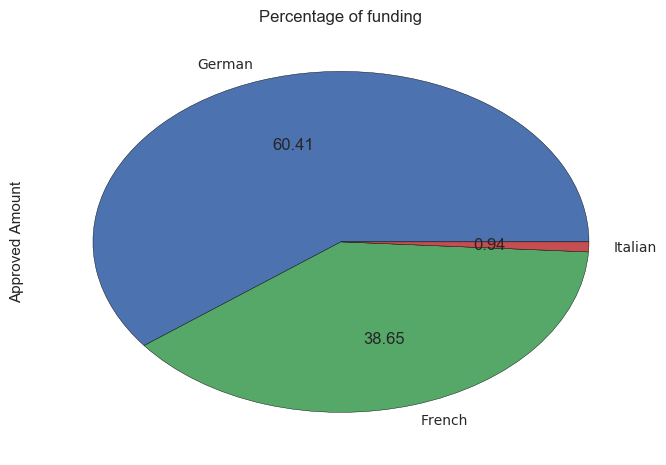

In [507]:
rosti_sum_by_lang = rosti_amount.groupby(['Language']).sum()['Approved Amount']
rosti_sum_by_lang.plot(kind='pie', labels=['German', 'French', 'Italian'], autopct='%.2f', title='Percentage of funding')